# Analyzing Summoners' Play Rates and Churn Rates vs Time

This notebook is split up into a few parts based on the different analyses we do, these are:

**1. The time between one summoner's games ($\Delta t$) as a function of time.**
<br>
<br>
**2. The time between a summoner's games as a function of time for 10 summoners.**
<br>
<br>
**3. Time series analysis of the average number of games played per day for all summoners in our dataset as a function of time.**
<br>
<br>
**4. The number of summoners who churned or almost churned vs time.**
<br>
<br>
**5. Games played per session vs time of summoners who churned or almost churned.**

For more explanation on $\Delta t$ you can check out *Appendix_A.ipynb*.

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from riotwatcher import LolWatcher

# I get this because of a copy warning using dataframes. More info is found here:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
# Ignoring all warnings is a horrible practice if you are running the code for the first time.
# However, upon further research I deemed the warning irrelevant, so I suppress it to make the output clean.
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data Cleaning

We get data from Riot's API using the Riotwatcher package found here: https://github.com/pseudonym117/Riot-Watcher

However, the data is a little bit dirty and must be cleaned. I denote how the data is dirty and how I clean it below:

- The time stamp of the start of the game and the duration of the game that we get from Riot's API is in milliseconds instead of seconds, so we convert it to seconds, so we can then convert that into a datetime object using the datetime package.
<br>
<br>

- For some game modes (such as practice tool), the unix timestamp is listed as 0. A unix timestamp of 0 corresponds corresponds to the date that the unix timestamp timer started which is sometime in 1970, so this time given is incorrect. There isn't really a good way to treat this, so we will just delete these games from our data. This causes a problem where if a summoner played a practice tool game and then played some other game, then the $\Delta t$ that would get recorded corresponds to the time difference of the games after and before the practice tool game. For now we will ignore this, but some ways we can deal with this is either ommit players who play practice tool games, or when getting date using Riotwatcher, interpolate the timestamp according to the fetched games before and after the practice tool game. This is probably the best way to work with this data and I will improve this project that way in the future.
<br>
<br>

- Other misc. ways the data is dirty, which is a fault of mine in terms of how I saved data to file and other reasons. I will explain these in the comments.

In [2]:
def clean_data(df):
    
    #A little after the time when Riot started adding timestamps to their data 
    #This is known as a Unix time stamp. 
    beginning = 1623987436 #June 18, 2021
    
    
    #Naming the columns
    df.columns = ["puuid", "match_id", "start_time", "duration"]

    
    #Drop duplicate values
    df.drop_duplicates(inplace=True)

    
    #Start time is measured in unix timestamp ms, so we convert to unix timestamp seconds
    df["start_time_seconds"] = df["start_time"]/1000

    
    #Creating column of datetimes for the start time of games
    df["start_time_date"] = df["start_time_seconds"].apply(lambda x : datetime.datetime.fromtimestamp(int(x)))
    
    
    #There are some games where the timestamps are messed up and start at 0, corresponding to 1970 (look up unix time)
    #So we remove these
    df = df[df["start_time_seconds"] > beginning]
    
    
    #duration is sometimes measured in seconds and sometimes in ms, so we conver to seconds via the condition:
    # If the duration of a game is in seconds, then when converting to minutes, if the duration is longer than 
    # 2 hours, we know this is far too long for a game, so the duration must actually be in ms, so we convert.
    df["duration_seconds"] = df["duration"].apply(lambda x : x/1000  if x/60 > 120 else x)

    
    #create a column for end_time since this is not tracked in all of the json files so we create it here
    df["end_time_seconds"] = df["start_time_seconds"] + df["duration_seconds"]

    
    #Sort the values by start_time
    df.sort_values(by = "start_time_seconds", ascending=True, inplace=True, ignore_index=True)

    
    #Creating a new column which measures the time difference between the start of a game and the end 
    # of the previous one
    del_t = []
    del_t.append(0)

    
    for i in range(1,len(df["start_time_seconds"])):

        del_t.append(df["start_time_seconds"][i] - df["end_time_seconds"][i-1])

        
    #In seconds
    df["del_t"] = del_t

    
    #Want the time between games in hours
    df["del_t_hours"] = df["del_t"]/(60*60)
    
    
    return(df)

# 1. Time Between Games Played for one LoL Player

Let's do a little bit of analysis for $\Delta t$ for games played by a single LoL Player over a period of a few months.

Sometime last year I played a game of LoL. In that game there were 10 players total, including myself. This section portrays $\Delta t$ as a function of time for one of those players over a period of sevaral months.

In [3]:
df = pd.read_csv("Player_Time_Data_2/player_0_times.txt",
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
df = clean_data(df)

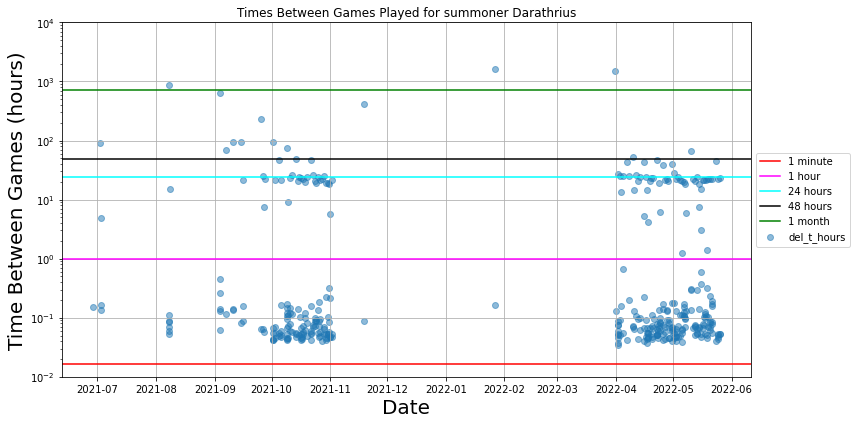

In [4]:
fig, ax = plt.subplots(figsize = (12,6))

ax.scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)

#Creating horizontal lines represening delta t's of sevaral values
ax.axhline(y = 1/60,   c = "red",     label = "1 minute")
ax.axhline(y = 1,      c = "magenta", label = "1 hour")
ax.axhline(y = 24,     c = "cyan",    label = "24 hours")
ax.axhline(y = 48,     c = "black",   label = "48 hours")
ax.axhline(y = 24*30,  c = "green",   label = "1 month")


#Need a log scale because some data points are far larger than others, especially if a player 
# has almost churned
ax.set_yscale("log")

plt.xlabel("Date", fontsize = 20)
plt.ylabel("Time Between Games (hours)", fontsize = 20)


watcher = LolWatcher(api_key="RGAPI-7244875a-e036-4863-8847-90e82ef35c7e")
summoner_name = watcher.summoner.by_puuid('na1',df["puuid"][0])["name"]

plt.title("Times Between Games Played for summoner {}".format(summoner_name))


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.ylim(.01,10000)
plt.tight_layout()

plt.savefig("Plots/del_t_vs_time_1_summoner.png")

In the plot above, on the x-axis is the start time of a game in terms of the date. On the y-axis is the time between the start of that game and the end of the previous game, $\Delta t$. This is the key metric we wish to analyze as it determines if a player almost churned: if $\Delta t$ is very large, it means it's the first time a summoner played a game in a long period of time. 
<br>
<br>

From the plot above, there are about 5 points where $\Delta t \approx 1 month$, meaning that it had been about a month since the last time the summoner played a game. Depending on what criteria you use, it can be argued that this summoner almost churned about 5 times.

# 2. Time Between Games Played for 10 LoL Players

**We now try to analyze $\Delta t$ vs $t$ of 10 LoL players and see if we can gain any insights from these plots.**

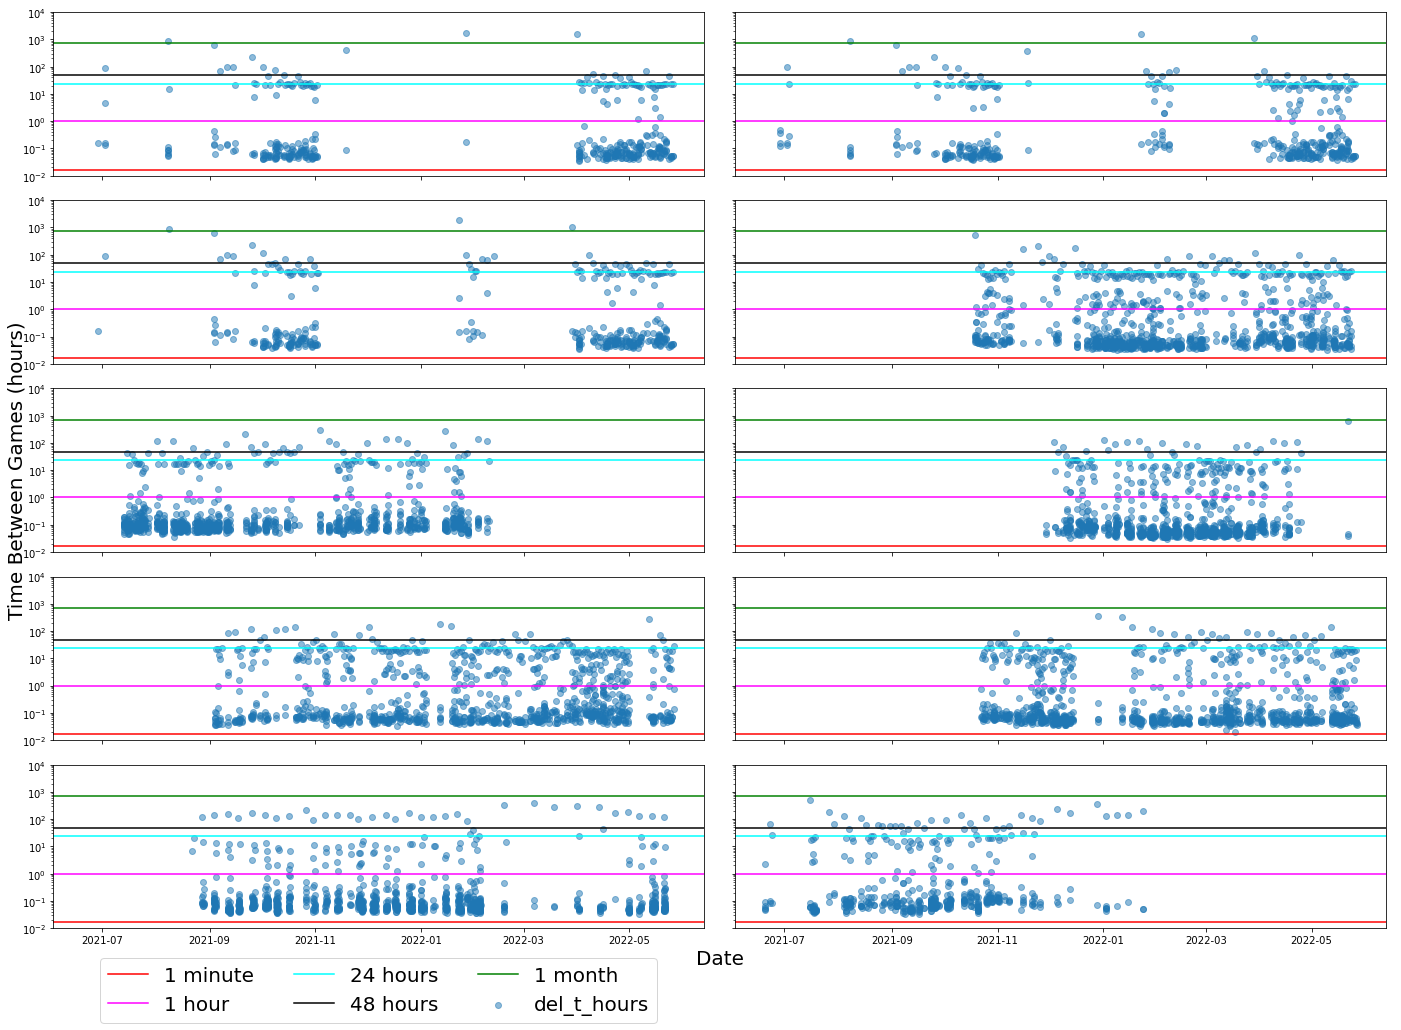

In [5]:
fig, axes = plt.subplots(nrows = 5, 
                       ncols=2, 
                       figsize = (20,15), 
                       sharex=True, 
                       sharey=True)


axis_list = [(0,0),(0,1),(1,0),(1,1),(2,0),(2,1),(3,0),(3,1),(4,0),(4,1)]

for i, filepath in enumerate(os.listdir("Player_Time_Data_2/")):
    
    df = pd.read_csv("Player_Time_Data_2/{}".format(filepath),
                      dtype='str,str,float,float', 
                      delimiter = " ",
                      usecols=(0,1,2,3),
                      header = None
                    )
    
    df = clean_data(df)
    
    axes[axis_list[i]].scatter(x = "start_time_date", y = "del_t_hours", data = df, alpha = .5)
    
    
    axes[axis_list[i]].axhline(y = 1/60,c = "red", label = "1 minute")
    axes[axis_list[i]].axhline(y = 1,   c = "magenta", label = "1 hour")
    axes[axis_list[i]].axhline(y = 24,  c = "cyan", label = "24 hours")
    axes[axis_list[i]].axhline(y = 48,  c = "black", label = "48 hours")
    axes[axis_list[i]].axhline(y = 24*30,  c = "green", label = "1 month")
    
    axes[axis_list[i]].set_yscale("log")
    

    plt.ylim(.01,10000)


#Code I got online to format x and y labels correctly
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Time Between Games (hours)", fontsize = 20)

#Code I got online to format legend correctly
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
axes.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, prop={'size': 20})    


plt.tight_layout()

plt.savefig("Plots/del_t_vs_time_10_summoners.png")

There are a few summoners who almost churned, represented by large gaps in points within a plot. In fact there are 3 summoners with very similar plots who all almost chured a few times. Upon checking op.gg, I find that these 3 players almost exlcusively queue up together. It makes sense that they almost churn at the same times as well. They all came back to LoL together it seems. Neat!

We also find from this analysis that two players actually churned, shown in plots (1,1) and (2,0). *I hope they do return to the rift*.

# Many Summoners' Data Analysis

Ok, so we explored a bit an individual summoner's game trends, and a group of 10 summoners' game trends. How do we explore data of many many summoners?

For N = 144 summoners, I acquired the start times and durations of every one of their games played from **June 18, 2021** to **May 28, 2022**. There are two analyses that I do in the next sections of this notebook:

1. I create a histogram counting the average number of games played per day by all the players. Since this is a time series we can do time series analysis to look for any noticeable patterns.
<br>
<br>
2. I get the date of the last game played by each summoner. I then create a histogram of these values. If the last game played by a summoner was 2 months before May 28, 2022 then I consider them as churned. If it's 1 month before then I consier these summoners as almost churned. Othwerwise, I still consider them as still playing the game.
<br>
<br>
3. For these players who churned or almost churned, I analyze the number of games played per gaming session as a function of time.

**But first, we must clean the data.**

## Cleaning

We have time data from N = 144 summoners which are contained in separate files, so we must join them together. We must also clean the data, I create a dataframe for each file of data, clean it, do this for all available summoner data sets, then join them into one new dataframe called df_new. However, in the code I wrote I clean each dataframe before I join them. This next batch of code explains my cleaning process in a very similar way to my earlier function by the same name.
<br>
<br>
**The only difference is the number of columns of the dataframes so you can skip this next cell if you wish.**




In [6]:
def clean_data(df):
    
    #A little after the time when Riot started adding timestamps to their data 
    #This is known as a Unix time stamp. 
    beginning = 1623987436 #June 18, 2021
    
    
    #Naming the columns. For this data I also got data on if the summoner won their game or not, although
    # I do not use this in this project.
    df.columns = ["puuid", "match_id", "start_time", "duration", "win"]

    #Drop duplicate values
    df.drop_duplicates(inplace=True)

    #Changing from milliseconds to seconds
    df["start_time_seconds"] = df["start_time"]/1000

    #Creating column of datetimes for the start time of games
    df["start_time_date"] = df["start_time_seconds"].apply(lambda x : datetime.datetime.fromtimestamp(int(x)))

    
    #There are some games where the timestamps are messed up and start at 0, corresponding to 1970 (look up unix time)
    #So we remove these
    df = df[df["start_time_seconds"] > beginning]
    
    
    #duration is sometimes measured in seconds and sometimes in ms, so we convert to seconds via the
    # same condition as given earlier.
    df["duration_seconds"] = df["duration"].apply(lambda x : x/1000  if x/60 > 120 else x)

    #create a column for end_time since this is not tracked in all of the json files
    df["end_time_seconds"] = df["start_time_seconds"] + df["duration_seconds"]

    #Sort the values by start_time
    df.sort_values(by = "start_time_seconds", ascending=True, inplace=True, ignore_index=True)

    #Creating a new column which measures the time difference between the start of a game and the end 
    # of the previous one
    del_t = []
    del_t.append(0)

    for i in range(1,len(df["start_time_seconds"])):

        del_t.append(df["start_time_seconds"][i] - df["end_time_seconds"][i-1])

    #In seconds
    df["del_t"] = del_t

    #Want the time between games in hours
    df["del_t_hours"] = df["del_t"]/(60*60)
    
    return(df)

I now combine all 144 summoners' data into one large dataframe.

In [7]:
#Getting all available files, combining them into one dataframe 

for i, file in enumerate(os.listdir("Player_Time_Data_Large_2/")):
    
    #Had some issues where notebook checkpoints were being read in so I include this line to ommit this file
    if file == ".ipynb_checkpoints": continue
    
    df = pd.read_csv("Player_Time_Data_Large_2/{}".format(file),
                      dtype='str,str,float,float,bool', 
                      delimiter = " ",
                      usecols=(0,1,2,3,4),
                      header = None
                    )

    df = clean_data(df)

    if i == 0:
        df_new = df
    
    else:
        df_new = pd.concat([df_new, df], ignore_index = True)

df_new.drop_duplicates(inplace = True)

We can split up the timeframe into different time slices, and **group up games according to the time they began.**  
For this project our slices are 1 day long.

In [8]:
#We create a list of time stamps which we will use in the next cell.
date_stamps = pd.date_range('2021-06-17', '2022-05-28', freq='D')

In [9]:
#Creating function that will assign each datetime an index corresponding to the position
# of the date of the datetime within the time_stamps list. For example if the datetime is 2022-03-02 19:34:32 
#then this index will be the one corresponding to the position of 2022-03-02 in the time_stamps list.

def date_slice_assign(start_date):
    
    for i in range(len(date_stamps)):
        
        if (date_stamps[i] <= start_date) and (start_date < date_stamps[i+1]):
            
            return (date_stamps[i])
    

In [10]:
#This code may take awhile depending on the time between dates you've chosen
#So both of these 2 snippets of code do the same thing, but the second one lets you keep track of which
# row you're on.

df_new["date_slice"] = df_new["start_time_date"].apply(date_slice_assign)

#date_list = []
#
#for i, date in enumerate(df_new["start_time_date"]):
#    
#    date_list.append(date_slice_assign(date))
#    print("added {}th date of {}, with date of {}".format(i, len(df_new["start_time_date"]),date_slice_assign(date)))
#    
#df_new["date_slice"] = date_list

# 3. Games Played Per Day

Now that we have a dataframe with all games played by 144 different summoners we can aggregate by days in order to find the average number of games played per day by the summoners in our dataset.

In [11]:
#We group by our new date_slice column and cout the number of games played per day by all 
# summoners in our dataset
grouped_df_date = df_new.groupby("date_slice").count()
grouped_df_date.head(3)

,puuid,match_id,start_time,duration,win,start_time_seconds,start_time_date,duration_seconds,end_time_seconds,del_t,del_t_hours
date_slice,,,,,,,,,,,
2021-06-17,77,77,77,77,77,77,77,77,77,77,77
2021-06-18,289,289,289,289,289,289,289,289,289,289,289
2021-06-19,273,273,273,273,273,273,273,273,273,273,273


In [12]:
grouped_df_date.tail(3)

,puuid,match_id,start_time,duration,win,start_time_seconds,start_time_date,duration_seconds,end_time_seconds,del_t,del_t_hours
date_slice,,,,,,,,,,,
2022-05-25,393,393,393,393,393,393,393,393,393,393,393
2022-05-26,443,443,443,443,443,443,443,443,443,443,443
2022-05-27,251,251,251,251,251,251,251,251,251,251,251


I noticed that the first and last days are very low compared to the rest of the dataset. Then I realized that when I was taking the data I did not get the first or last day of my date at the start of those days, but at some arbitrary point in that day. This means that the entire day had not elapsed for these data points, thus I did not capture all of the games played for that day. So we will drop these data points. It's just 2 days out of 11 months, so it's no biggie.

In [13]:
#Dropping first and last data points corresponding to first and last date.
grouped_df_date.drop(index = [grouped_df_date.index.min(), grouped_df_date.index.max()], inplace = True)

In [14]:
#We turn the games played vs days into avg games played vs days, then into a Pandas Series 
# object to use with the time series analysis package: tsa

number_players = len(pd.unique(df_new["puuid"]))
counts_time_series = pd.Series(grouped_df_date["start_time_seconds"]/number_players)

We would like to see **if any noteable dates in the League of Legends community had any influence on the number of games played at or around that day.** These siginificant events that I include and their dates are listed below. 

In [15]:
noteable_dates = ["2022-05-25", 
                  "2022-01-05",  
                  "2021-11-06", 
                  "2021-10-05",
                  "2021-08-05"]

noteable_dates_labels = ["Durability Update", 
                         "Start of Season 12", 
                         "Arcane Show Aired / Worlds Final",
                         "Worlds 2021 Starts",
                         "LCS/LCK Final"]

color_list = ["r", "k", "green", "purple", "orange"]

**Now, we plot the average number of games played per day as a function of time.**

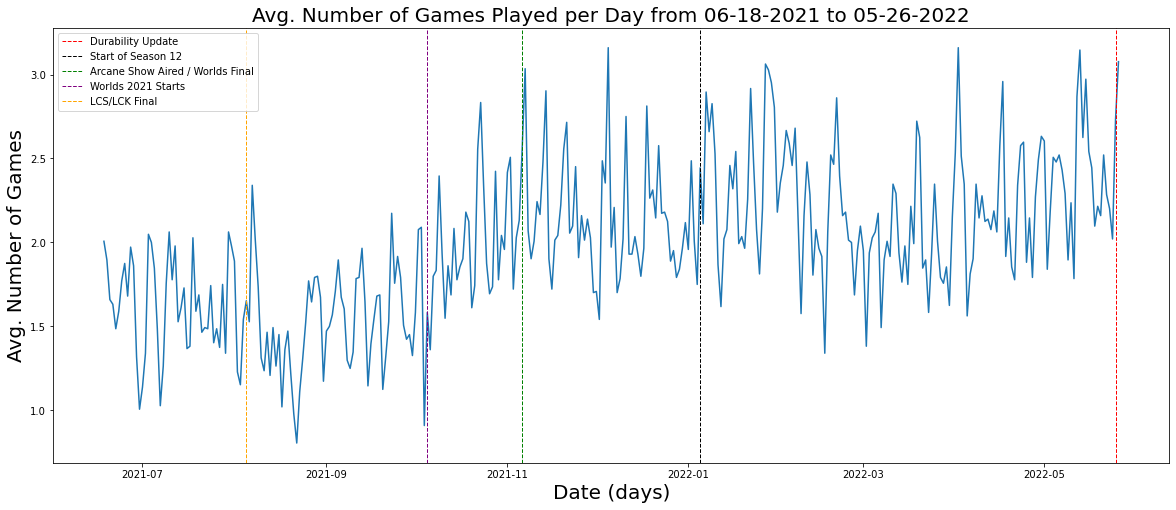

In [16]:
plt.figure(figsize = (20,8))

sns.lineplot(x = counts_time_series.index,
             y = counts_time_series,
             )

for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = datetime.datetime.strptime(date, "%Y-%m-%d"), 
                label = noteable_dates_labels[i], 
                c = color_list[i],
                ls = "--",
                lw = 1
               )
    
plt.legend(loc = "best")
plt.xlabel("Date (days)", fontsize = 20)
plt.ylabel("Avg. Number of Games", fontsize = 20)
plt.title("Avg. Number of Games Played per Day from 06-18-2021 to 05-26-2022", fontsize = 20)


plt.savefig("Plots/Avg_Games_Played_per_Day_Total.png")

The data seems to be incredibly volatile and has no pattern I can see except that it goes up a little then stagnates at around December 2021. We will have to do time series decomposition in order to separate the trend and seasonality from this data.
<br>
<br>
We do this by making the assumption that this time series is made up of 3 differente parts added together, trend, seasonality, error, which you can think of as follows:

- **Trend**: Tells you the general direction of where the time series is going, given by a rolling average of the data. Since our dataset consists soley of veteran players, we expect that the trend will be stagnant and not increase or decrease unless affected by some outside influence.
<br>
<br>
- **Seasonality**: Tells you the cyclic pattern of the time series. Since our time series goes by days, we expect our cycles to be a day, a week or a month long.
<br>
<br>
- **Error**: Tells you information on the time series that does not involve the trend or seasonality. In other words if the time series is only made up of these 3 parts, then the error tells you how factors outside of the general trend and seasonality affected your data at some point in time. 
<br>
<br>

**Let's decompose our time series into theses 3 components and analyze.**.

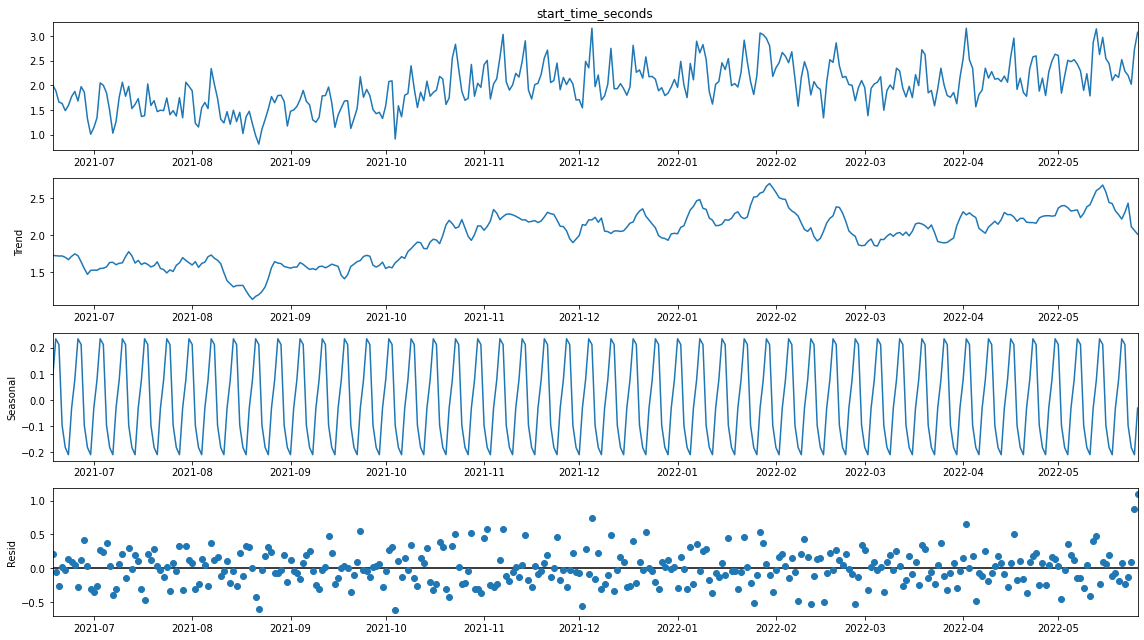

In [17]:
counts_decompose = seasonal_decompose(counts_time_series, extrapolate_trend="freq")

fig = counts_decompose.plot()

fig.set_size_inches((16, 9))
fig.tight_layout()



plt.savefig("Plots/Avg_Games_Played_per_Day_Decompose.png")

**Let's examine the game counts by each part of the time series:**

- Trend: Seems to be generally fluctuating, but around October 2021, seems to rise gradually. Then at about mid-February 2022 seems to fall a bit before rising again mid-March 2022.
<br>
<br>
- Seasonality: There appear to be 4 cycles between each month, corresponding to a weekly cycle (as we expected). This means that some days of the week, summoners play more and other parts summoners play less.
<br>
<br>
- Error: Hard to tell if there's a pattern because it's a scatterplot so **let's plot this on its own along with seasonality to see if it has any lingering effects on the residuals.**

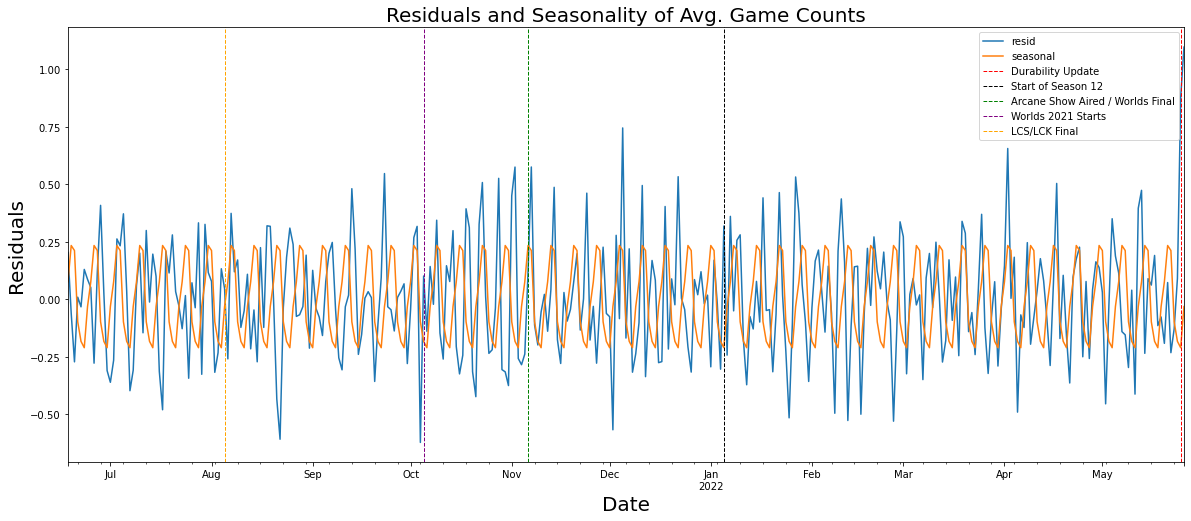

In [18]:
fig, ax = plt.subplots(figsize = (20,8))


counts_decompose.resid.plot(ax = ax)
counts_decompose.seasonal.plot(ax = ax)
plt.title("Residuals and Seasonality of Avg. Game Counts", fontsize = 20)
plt.ylabel("Residuals", fontsize = 20)
plt.xlabel("Date", fontsize = 20)


for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = date, 
                label = noteable_dates_labels[i], 
                c = color_list[i],
                ls = "--",
                lw = 1
               )
    
plt.legend(loc = "best")


plt.savefig("Plots/Avg_Games_Played_per_Day_Resid_Season.png")

The peaks and troughs of the seasonality part doesn't exactly line up with the peaks and troughs of the residuals.This makes me think that we have in fact removed the seasonality and these residuals are truly just random error. If this is the case then this is known as **white noise** Let's do a sanity check to see if we removed seasonality and trend. We conduct a **Dickey-Fuller test** for stationarity, if the p-value of this test less than .05 then the data is stationary, meaning there is no trend or seasonality anymore, which is what we expect and want by decomposing.

In [19]:
adft = adfuller(counts_decompose.resid,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

         Values                       Metric
0 -8.444974e+00              Test Statistics
1  1.722584e-13                      p-value
2  1.700000e+01             No. of lags used
3  3.250000e+02  Number of observations used
4 -3.450632e+00          critical value (1%)
5 -2.870474e+00          critical value (5%)
6 -2.571530e+00         critical value (10%)


We find that, according to the Dickey-Fuller test, **our residual is indeed stationary. Let's take a closer look at just the residuals.**

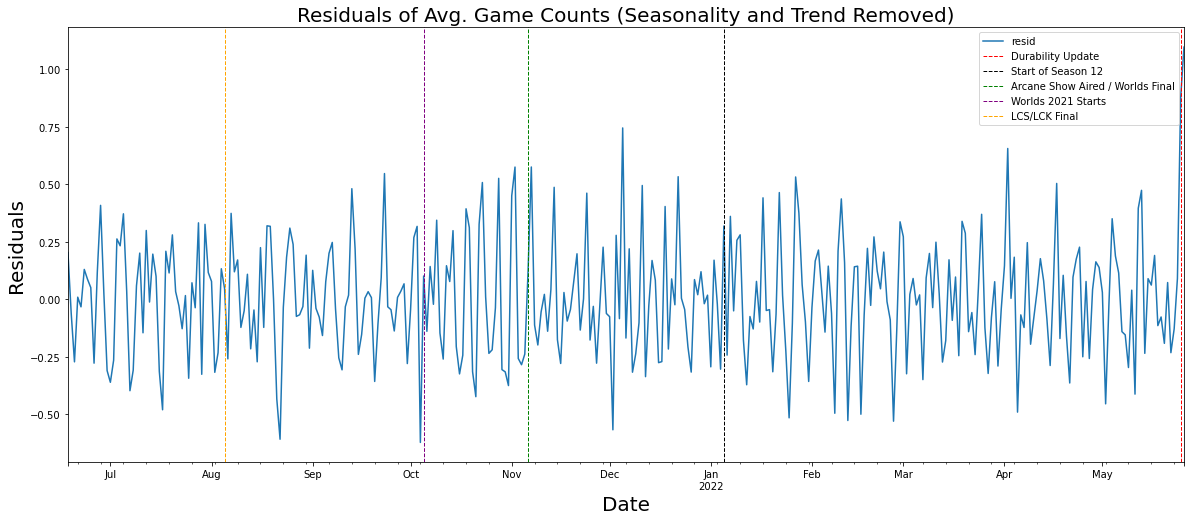

In [20]:
fig, ax = plt.subplots(figsize = (20,8))

counts_decompose.resid.plot(ax = ax)

plt.title("Residuals of Avg. Game Counts (Seasonality and Trend Removed)", fontsize = 20)
plt.ylabel("Residuals", fontsize = 20)
plt.xlabel("Date", fontsize = 20)


for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = date, 
                label = noteable_dates_labels[i], 
                c = color_list[i],
                ls = "--",
                lw = 1
               )
    
plt.legend(loc = "best")


plt.savefig("Plots/Avg_Games_Played_per_Day_Resid.png")

There doesn't appear to be any clear influence from our events list. Maybe some of our events line up with some of the peaks or troughs, but realistically there are so many peaks and troughs that we would just be grasping at straws.
<br>
<br>
**The only pattern we see is in the trend, let's take a closer to look at what I mean.**

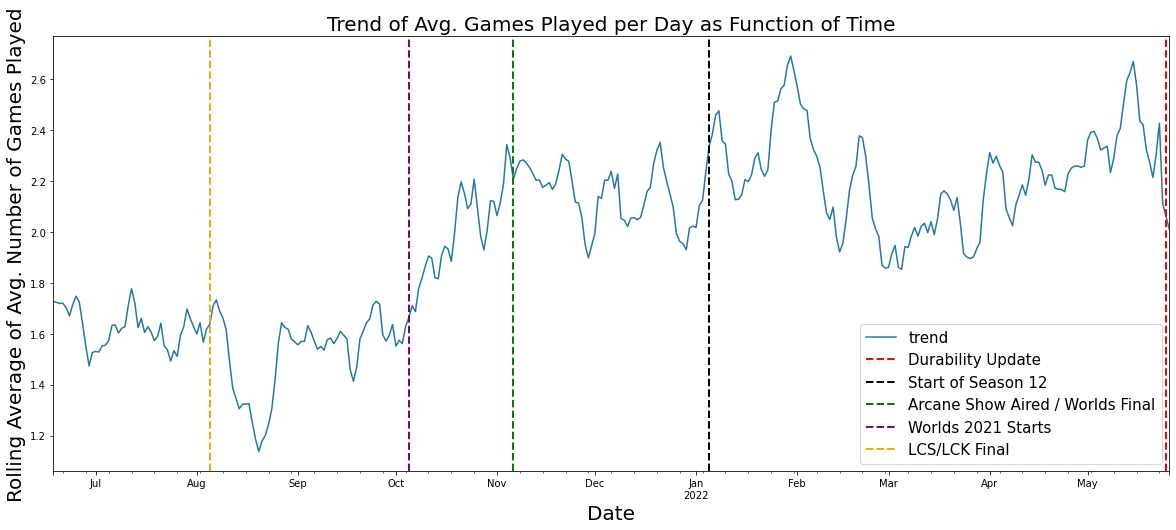

In [21]:
fig, ax = plt.subplots(figsize = (20,8))

counts_decompose.trend.plot(ax = ax)

plt.title("Trend of Avg. Games Played per Day as Function of Time", fontsize = 20)
plt.ylabel("Rolling Average of Avg. Number of Games Played", fontsize = 20)
plt.xlabel("Date", fontsize = 20)


for i, date in enumerate(noteable_dates):
    
    plt.axvline(x = date, 
                label = noteable_dates_labels[i], 
                c = color_list[i],
                ls = "--",
                lw = 2
               )
    
plt.legend(loc = "best", fontsize = 15)


plt.savefig("Plots/Avg_Games_Played_per_Day_Trend.png")

By looking at the trend, it seems as if the beginning of Worlds 2021 influenced summoners to play more overall over the next few months.

It doesn't seem as if the other events had any major influence on the trend.

We can conduct a **chanepoint analysis** to see if there is a statistically significant change in the trend of this time series. However, there is no straightforward-to-use library that implements this in Python (whereas this is trivial in R) and I will leave this as a future task for this project.

# 4. Summoners Churned/Almost Churned vs Time

We defined a summoner as **almost churning** if they have not played a game in a month since the last time we have taken in data, which was May 28th, 2022. So if they had not played on or after March 28th, 2022, we consider these players as almost churned.

We defined a summoner as **completely churned** if they have not played for over 2 months since the last time we have taken in data, which was May 28th, 2022. So if they had not played on or after March 28th, 2022, we consider these players as churned.

We analyze our dataset to find which summoners meet the above criteria and when did they churn or almost churn. First, we **create a list of the last game played for each summoner in our dataset.**

In [22]:
#List of summoner puuids of entire dataset
puuids = df_new["puuid"].unique()

#Date of the last game played for each summnoner, most will be the last day data was taken
last_game_dates = [] 


for puuid in puuids:
    
    last_game_date = df_new[df_new["puuid"] == puuid].sort_values(by = "start_time_date", ascending = False)["start_time_date"].iloc[0]
    
    last_game_dates.append(last_game_date)


Then, we **find the number of summoners who churned, almost churned, and are still considered as playing the game.**

In [23]:
#Getting the number of summoners who churned, almost churned, and are still playing LoL

summoners_churned = sum([date < date_stamps[-1] - datetime.timedelta(days = 61) for date in last_game_dates])

summoners_almost_churned = sum([(date_stamps[-1] - datetime.timedelta(days = 61) <= date) & (date < date_stamps[-1] - datetime.timedelta(days = 30)) for date in last_game_dates])

summoners_stayed = sum([date_stamps[-1] - datetime.timedelta(days = 30) <= date for date in last_game_dates])


summoners_sum = summoners_churned + summoners_almost_churned + summoners_stayed

summoners_churned_per = summoners_churned/summoners_sum * 100
summoners_almost_churned_per = summoners_almost_churned/summoners_sum * 100
summoners_stayed_per = summoners_stayed/summoners_sum * 100

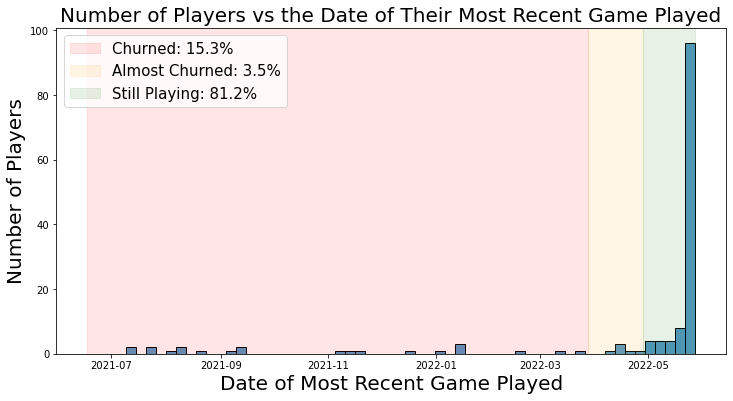

In [24]:
plt.figure(figsize = (12,6))

sns.histplot(last_game_dates)


plt.axvspan(date_stamps[0], date_stamps[-1] - datetime.timedelta(days = 61), color='red', alpha=0.1, label = "Churned: {:.1f}%".format(summoners_churned_per))
plt.axvspan(date_stamps[-1] - datetime.timedelta(days = 61), date_stamps[-1] - datetime.timedelta(days = 30), color='orange', alpha=0.1, label = "Almost Churned: {:.1f}%".format(summoners_almost_churned_per))
plt.axvspan(date_stamps[-1] - datetime.timedelta(days = 30), date_stamps[-1], color='green', alpha=0.1, label = "Still Playing: {:.1f}%".format(summoners_stayed_per))


plt.ylabel("Number of Players", fontsize = 20)
plt.xlabel("Date of Most Recent Game Played", fontsize = 20)
plt.title("Number of Players vs the Date of Their Most Recent Game Played", fontsize = 20)
plt.legend(fontsize = 15)

plt.savefig("Plots/Number_of_Players_vs_Last_Game_Played.png")

In [25]:
print("Since July 18, there have been {} summoners who have churned and {} who have almost churned out of {} total summoners whose data we acquired".format(summoners_churned,summoners_almost_churned, len(puuids)))

Since July 18, there have been 22 summoners who have churned and 5 who have almost churned out of 144 total summoners whose data we acquired


We need more data in order to get any insights into the average number of players churning as a function of time as we only have 22 data points for this.

# 5. Games Played per Session vs Time

Here we analyze for every player who churned or almost churned the **number of games per session as a function of time**. 

A game belongs to a gaming session if the time between the start of this game and the end of the previous one ($\Delta t$) is less than two hours. We choose two hours because, althought it's a long time between a game, we don't believe it's long enough time to pass for those games to be considered as part of a different sit-down game sesison. It's likely those players are just taking a break by eating or something else.

Now that we have defined what a session is, we predict that summoners were playing less games per session right before churning or almost churning. 

Here is the simple algorithm I use to group games into within a session or in a separate session for each summoner:

0. Order their games played by the start time of their games.
<br>
<br>
1. Choose the first game.
<br>
<br>
2. This game will be assigned to sessin i=0, because it is the first game.
<br>
<br>
3. Choose the next game.
<br>
<br>
4. If the time between the start of this game and the end of its previous game is less than 2 hours, this game is part of that play session i. 
<br>
<br>
5. If it's not, then this game is part of a new session i+1.
<br>
<br>
6. Go back to step 3 and repeat for all games.

**For a more in-depth discussion on time between games and session separations I encourage you to please see Appendix_A.ipynb.**

**Now, we get data of the summoners who churned or almost churned. We start off by getting the puuids' of these summoners.**

In [26]:
#Getting the players' puuids who churned or almost churned

puuid_churned = []

for puuid in pd.unique(df_new["puuid"]):
    
    df = df_new[df_new["puuid"] == puuid]
    
    last_game = pd.Timestamp.to_datetime64(df_new[df_new["puuid"] == puuid].sort_values(by = "start_time_date", ascending = False)["start_time_date"].iloc[0])
    
    if last_game < pd.Timestamp.to_datetime64(date_stamps[-1] - datetime.timedelta(days = 30)):
        puuid_churned.append(puuid)


**Next, we add concatenate all the summoners' data who churned or almost churned into one dataframe called df_churn_al_churn.**

In [27]:
#Adding all the players who churned data to a dataframe

for puuid in puuid_churned:

    if puuid == puuid_churned[0]: 
        df_temp = df_new[df_new["puuid"] == puuid]
        
    else: 
        df_temp = pd.concat([df_temp, df_new[df_new["puuid"]== puuid]])
    
df_churn_al_churn = df_temp

**Now, we go through the algorithm mentioned earlier to designate if each game is part of which play session.**

We do this for each summoners' dataframe and add the column designating which game is part of which game session. Then we concatenate to a new dataframe along with all other summoners' dataframes.

In [28]:
#Assigning session numbers to each row in the dataframe

#summoners who churned or almost churned
for puuid in puuid_churned:
    
    #Creating a temporary dataframe
    df_temp = df_churn_al_churn[df_churn_al_churn["puuid"] == puuid].sort_values(by = "start_time_date", ascending = True)
    
    #List of games per session
    sessions = [] 
    
    #Loop below goes through i, but there are nested loops that increment i. So that we don't count twice, we
    # append those i's to this list and then ignore the for loop if it goes through these i's.
    index_ignore = []
    
    #Assigns a session number to each game
    session_counter = 0
    
    #Go through each game 
    for i in range(len(df_temp["del_t_hours"])):      
        
        #Get the delta t of a game
        del_t = df_temp["del_t_hours"].iloc[i]
        
        #If we counted this game already, go to the next iteration
        if i in index_ignore: 
            continue      
        
        #If game is part of a new session
        elif (2 <= del_t):
            
            #Assign session number to game
            sessions.append(session_counter)
            
            #Make sure we ignore this i if code tries to iterate over it again
            index_ignore.append(i)
             
            #Check if next game is in this session or not  
            while True:
                #increment
                i+=1
                
                #If we are at the final game for this player, then break out of the loop
                if i == len(df_temp["del_t_hours"]): 
                    break
                
                #If game is still within this session
                if (df_temp["del_t_hours"].iloc[i] < 2):
                    
                    #Assign this game same session number as loop above in hierarchy
                    sessions.append(session_counter)
                    
                    #Make sure we ignore this i if code tries to iterate over it again
                    index_ignore.append(i)
                
                #If next game is not in the same session then increase session number
                # and go to next game
                else: 
                    session_counter += 1
                    break
                
        # If this is the first game in a dataframe 
        else: 
            
            #Assign session number to game
            sessions.append(session_counter)
            
            #Make sure we ignore this i if code tries to iterate over it again
            index_ignore.append(i)
            
            #Check if next game is in this session or not          
            while True:  
                #increment
                i+=1
                
                #If game is still within this session             
                if (df_temp["del_t_hours"].iloc[i] < 2):
                    
                    #Assign this game same session number as loop above in hierarchy
                    sessions.append(session_counter)
                
                    #Make sure we ignore this i if code tries to iterate over it again
                    index_ignore.append(i)
                
                
                #If next game is not in the same session then increase session number
                # and go to next game
                else: 
                    session_counter += 1
                    break
    
    #For this summoner, create a new column of sesion number for each game
    df_temp["session"] = sessions
    
    #For the first summoner assign df_temp to a df_temp_new
    if puuid == puuid_churned[0]: 
        df_temp_new = df_temp
    
    #For ever summoner after, concatenate their df's together
    else: 
        df_temp_new = pd.concat([df_temp_new, df_temp])

#After all summoners are iterated over, assign a final dataframe
df_churn_al_churn = df_temp_new

So what we have just done is for each game we assinged an integer representing wich game session that game was a part of. Now, how about we analyze the amount of games per session as a function of time. We do this by:

1. For every game session, we aggregate the games in that session by counting them. We call this the **session count** and is the number of games played in that session.
<br>
<br>
2. For each session count we assign it the datetime value of the datetime of the first game in that session.
<br>
<br>
3. We plot **session counts vs time** for each summoner who churned or almost churned and analyze any patterns. 

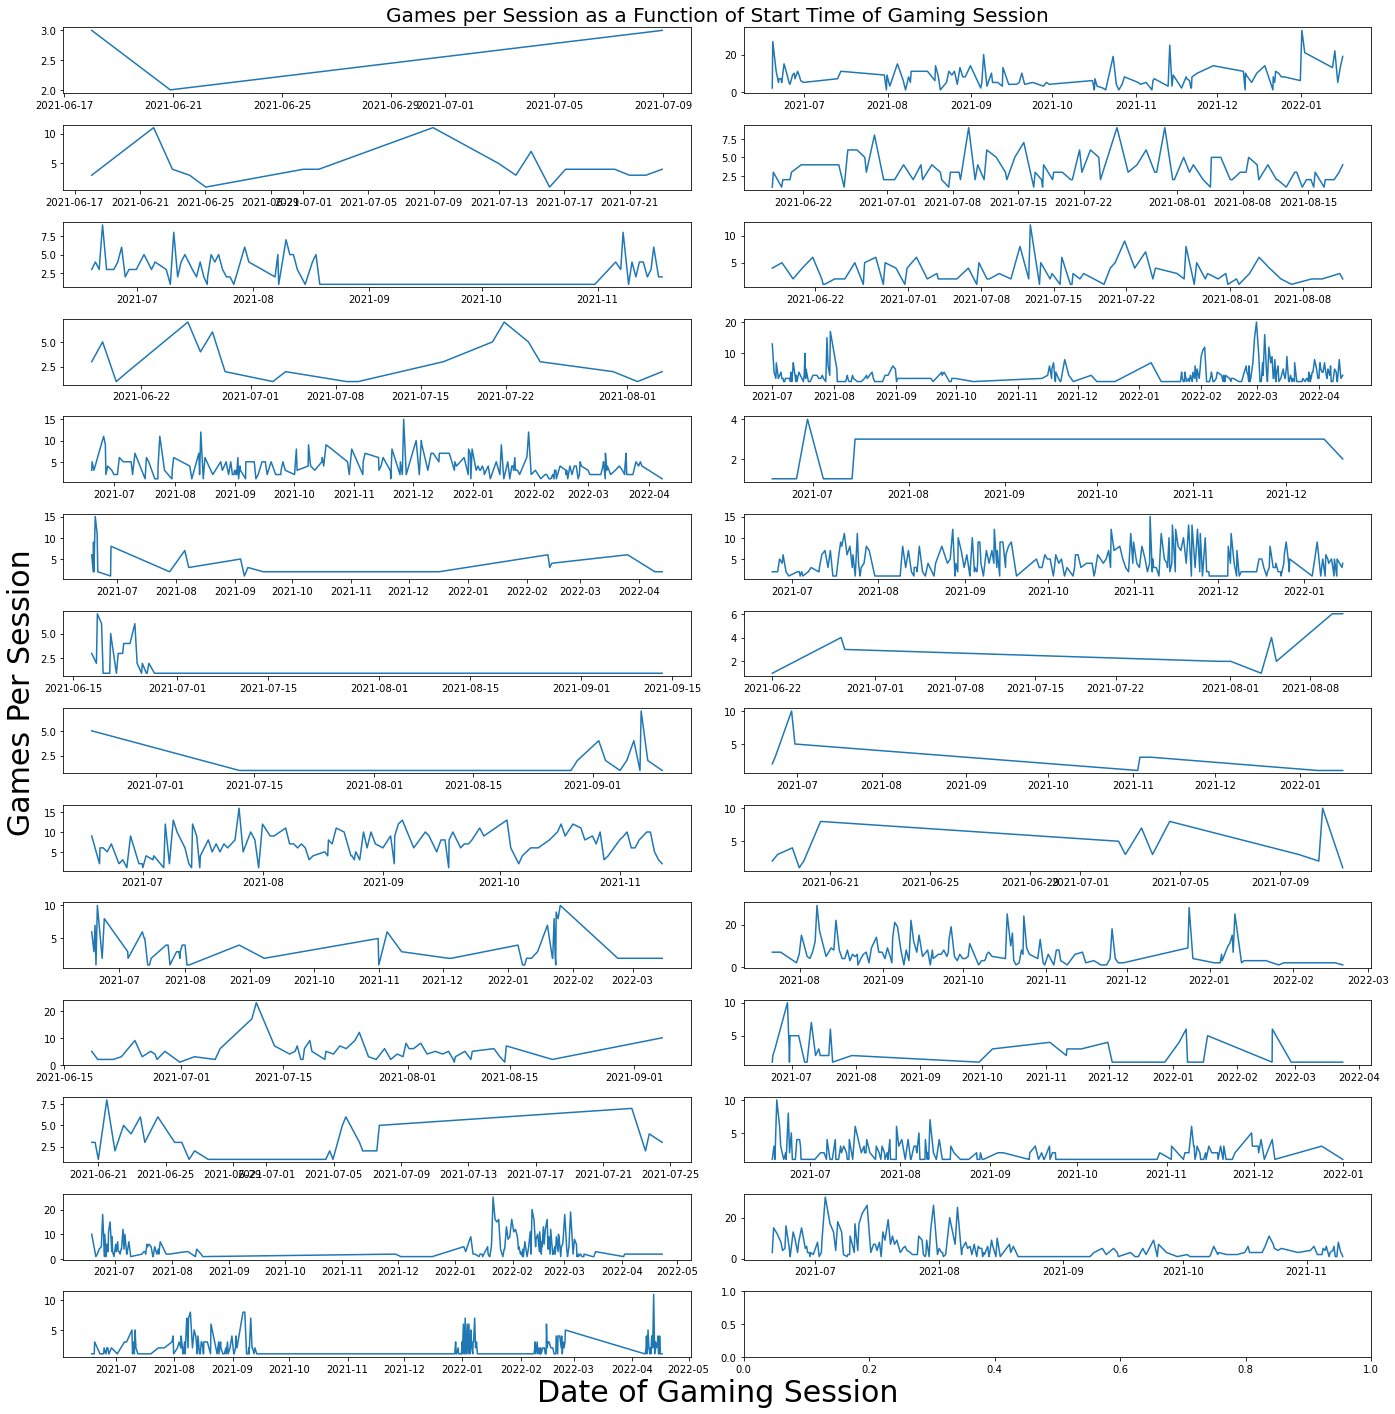

In [29]:
#Creating 28 plots to fit 27 summoners' data in.
fig, ax = plt.subplots(nrows = 14, 
                       ncols=2, 
                       figsize = (20,20), 
                      )

#Create a list of tuples, designating the location of the plot.
tuple_list = []

for i in range(14):
    for j in range(2):
        tuple_list.append((i,j))
        

#Iterating through each summoner who churned or almost churned
for j, puuid in enumerate(puuid_churned):    
    
    #Creating a temporary df for this summoners
    df_temp = df_churn_al_churn[df_churn_al_churn["puuid"] == puuid].sort_values("start_time_date")

    #The number of games per session. This list will be the length of the number of sessions.
    games_per_session = df_temp.groupby("session").count()["start_time_date"]
    
    #The datetime of the first game in a session
    session_date = df_temp.groupby("session").min()["start_time_date"]
        
    #Plotting the j'th plot ax, but we need a tuple to represent the position of the ax we want to plot on. 
    ax[tuple_list[j]].plot(session_date[:], games_per_session[:])    
    

#Code I got online that let's me format axes labels correctly
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
 
plt.xlabel("Date of Gaming Session", fontsize = 30)
plt.ylabel("Games Per Session", fontsize = 30)

plt.title("Games per Session as a Function of Start Time of Gaming Session", fontsize = 20)

plt.tight_layout() 

plt.savefig("Plots/Games_per_Session_vs_Time.png")

We look at the last few gaming sessions of the players that churned or almost churned and notice that **most of their last few sessions have a declining amount of games per session.** This is of course an eyeball approximation. If we wish to do a more in-depth analysis we would look at the last N amount of games for each of these players and try to do a time series decomposition and analyze the trend of the number of games played per session as a function of time. 

This would prove to be a difficult task as the time between points in these plots are not the same and we would need to do find a workaround for this, and perhaps interpolate between points to simulate equally spaced samples. 

I leave this as a future goal for this project.

# Conclusion

In this project we analyzed different metrics of summoners' games and made the following insights:

1. An **upward trend in average games played per day seemed to occur near the Worlds 2021 Final**.
<br>
<br>
2. **15.3% of players in our dataset have churned**, meaning that the last game they played was at least 2 months from the final date that we attempted to acquire data of games played for that player. Similarly, about **3.5% have almost churned**, meaningthat the last game they played was between 1 month and 2 months before the final date that we attempted to acquire data of games played for that player.
<br>
<br>
3. Of these players who churned or almost churned, we found that **the number of games per gaming session was decreasing nearing their final games played**. We must acquire more data and do a rigorous time series analyses of this data because **if a decrease in number of games played per sessionis an indicator of a player almost churning then Riot can attempt to entice the player to keep playing games via marketing techniques or incentives.**